In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"sreehar","key":"21cf35b91f53c122ef3b6578c794773e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip imdb-dataset-of-50k-movie-reviews.zip

kaggle.json
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  imdb-dataset-of-50k-movie-reviews.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from functools import reduce
from operator import iconcat
import re
import spacy
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
tqdm.pandas()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Vocab:
    def __init__(self, min_frequency, vocab_size):
        self.min_frequency = min_frequency
        self.vocab_size = vocab_size

    def build_vocab(self, df, field):
        df_freq = self.get_token_frequency(df, field)
        df_freq = df_freq.loc[df_freq["frequency"] >= self.min_frequency]
        df_freq = df_freq.head(self.vocab_size-1)
        self.counts = dict(zip(df_freq["token"], df_freq["frequency"]))
        df_freq["index"] = np.arange(0, df_freq.shape[0], 1)+1
        self.stoi = dict(zip(df_freq["token"], df_freq["index"]))
        self.itos = dict(zip(df_freq["index"], df_freq["token"]))

    def get_token_frequency(self, df, field):
        corpus = df[field].values.tolist()
        flattened_tokens = reduce(iconcat, corpus, [])
        vocab, counts = np.unique(flattened_tokens, return_counts=True)
        df_token_freq = pd.DataFrame(zip(vocab, counts),
                                     columns=["token", "frequency"])
        df_token_freq.sort_values(by="frequency",
                                  ascending=False, inplace=True)
        return df_token_freq

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, dataset_path, min_frequency,
                 vocab_size):
        self.min_frequency = min_frequency
        self.df = pd.read_csv(dataset_path)
        self.nlp = spacy.load("en_core_web_sm",
                              disable=['ner', 'parser', 'tagger'])
        
        # Preprocess target and text
        self.df["sentiment"] = self.df["sentiment"].\
            apply(lambda x: 1 if x == "positive" else 0)
        self.df["review_cleaned"] = self.df["review"].\
            progress_apply(self.tokenizer)
        self.vocab_builder = Vocab(min_frequency=self.min_frequency,
                                   vocab_size=vocab_size)
        self.vocab_builder.build_vocab(self.df, "review_cleaned")
        
        # Retain only those tokens in vocab
        self.df["review_cleaned"] = \
            self.df["review_cleaned"].progress_apply(lambda doc:
                                                     [token for token in doc
                                                      if token in self.vocab_builder.stoi.keys()])
        self.df["review_token_idx"] = self.df["review_cleaned"].progress_apply(lambda doc: 
                                                                               [self.vocab_builder.stoi[token] for token in doc] )
        self.df["len"] = self.df["review_token_idx"].apply(len)
        
    def tokenizer(self, doc):
        doc = doc.lower()
        doc = doc.replace("<br />", " ")
        doc = self.nlp(doc)
        lemmas = [re.sub(r'[^a-z0-9]+', ' ',
                         re.sub(r'http\S+', ' ', token.lemma_))
                  for token in doc]
        lemmas = [lemma.strip() for lemma in lemmas if lemma != " "]
        return lemmas

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):

        reviews = np.array(self.df.iloc[idx]["review_token_idx"])
        lengths = np.array(self.df.iloc[idx]["len"])
        sentiments = np.array(self.df.iloc[idx]["sentiment"])

        return {"features" : reviews,
                "len" : lengths, 
                "target" : sentiments}

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, embedding_dim, vocab_size, hidden_size):
        super(SentimentClassifier, self).__init__()
        self.emb = nn.Embedding(
                                num_embeddings=vocab_size,
                                embedding_dim=embedding_dim,
                                padding_idx=0)
        self.rnn = nn.LSTM(input_size = embedding_dim, 
                           hidden_size=hidden_size,
                           num_layers=1,
                           batch_first=True,
                           bidirectional=True)
        self.linear = nn.Linear(in_features=2*hidden_size,
                                out_features=128)
        self.linear2 = nn.Linear(in_features=128,
                                out_features=1)

    def forward(self, x_in):
        x, lengths = x_in
        embeddings = self.emb(x)
        packed_seq = pack_padded_sequence(embeddings,
                                          lengths, 
                                          batch_first=True, 
                                          enforce_sorted=False)
        outputs, (h_t, c_t) = self.rnn(packed_seq)
        hidden_states = torch.cat((h_t[-2, :, :], h_t[-1,:, :]), dim=1)
        hidden_states = nn.Dropout(p=0.4)(hidden_states)
        linear_out = self.linear(hidden_states)
        
        linear_out = self.linear2(linear_out)
        # Sigmoid
        score = torch.sigmoid(linear_out)  # [bs, 1+neg_ex]
        return score

In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    y_pred = model(xb)
    loss = loss_func(y_pred, yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(y_pred)

from sklearn.metrics import roc_auc_score
def get_metrics(model, xb, yb):
    y_pred = model(xb)
    score = roc_auc_score(yb.detach().cpu().numpy(), y_pred.detach().cpu().numpy())
    return score, len(y_pred)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_metrics_all, test_metrics_all = [], []
    train_loss_all, test_loss_all = [], []
    for epoch in range(epochs):
        
        model.train()
        losses, records = zip(*[loss_batch(model, loss_func, xb, yb, opt) for xb, yb in train_dl])
        train_loss = np.sum(np.multiply(losses, records)) / np.sum(records)
        
        model.eval()

        with torch.no_grad():
            losses, records = zip(*[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl])
            train_scores, train_records = zip(*[get_metrics(model, xb, yb) for xb, yb in train_dl])
            test_scores, test_records = zip(*[get_metrics(model, xb, yb) for xb, yb in test_dl])
            
        test_loss = np.sum(np.multiply(losses, records)) / np.sum(records)    
        
        train_metrics = np.sum(np.multiply(train_scores, train_records)) / np.sum(train_records)
        test_metrics = np.sum(np.multiply(test_scores, test_records)) / np.sum(test_records)
        
        train_loss_all.append(train_loss)
        test_loss_all.append(test_loss)

        train_metrics_all.append(train_metrics)
        test_metrics_all.append(test_metrics)

        print(f"""EPOCH: {epoch}|TRAIN LOSS: {train_loss:.8f}|TRAIN ROCAUC: {train_metrics:.8f}|TEST LOSS: {test_loss:.8f}|TEST ROCAUC: {test_metrics:.8f}""")
        
    return {"train_auc" : train_metrics_all, "test_auc": test_metrics_all, 
            "loss" : train_loss_all, "test_loss" : test_loss_all}



def plot_results(history):
  %matplotlib inline
  import matplotlib.pyplot as plt
  fig = plt.figure(figsize = (16, 4))
  fig.add_subplot(121)
  epochs = len(history["loss"])
  plt.plot(np.arange(0, epochs), history["loss"])
  plt.plot(np.arange(0, epochs), history["test_loss"])
  plt.title("Loss")
  plt.legend(["train", "test"])
  plt.xticks(np.arange(0, epochs, 1))
  plt.xlabel("epoch")
  
  fig.add_subplot(122)
  plt.plot(np.arange(0, epochs), history["train_auc"])
  plt.plot(np.arange(0, epochs), history["test_auc"])
  plt.ylim(0,1)
  plt.title("Metrics - AUC")
  plt.legend(["train", "test"])
  plt.xticks(np.arange(0, epochs, 1))
  plt.xlabel("epoch")
  plt.show()



In [ ]:


from torch.optim import Adam

VOCAB_SIZE = 3000
vocab_builder = Vocab(min_frequency=50, vocab_size=VOCAB_SIZE)
ds = SentimentDataset(dataset_path="/content/IMDB Dataset.csv", 
                      min_frequency=50, vocab_size=3000)
train_length = int(len(ds)*0.8)
test_length = int(len(ds)*0.2)
train_ds, test_ds = random_split(ds, lengths = [train_length, test_length])



100%|██████████| 50000/50000 [00:02<00:00, 22296.70it/s]


In [ ]:
def collate_fn(batch):
  reviews = [torch.tensor(x["features"]) for x in batch]
  lens = [torch.tensor(x["len"]) for x in batch]
  target = [torch.tensor(x["target"]) for x in batch]

  padded_reviews = pad_sequence(reviews, batch_first=True, padding_value=0)
  lens = torch.tensor(lens)
  target = torch.tensor(target).reshape(-1,1)
  return (padded_reviews.long().to(device), lens.float().to(device)), target.float().to(device)

EPOCH: 0|TRAIN LOSS: 0.55662359|TRAIN ROCAUC: 0.83830599|TEST LOSS: 0.50352196|TEST ROCAUC: 0.83276453
EPOCH: 1|TRAIN LOSS: 0.42292151|TRAIN ROCAUC: 0.93468686|TEST LOSS: 0.35148366|TEST ROCAUC: 0.92491419
EPOCH: 2|TRAIN LOSS: 0.32964368|TRAIN ROCAUC: 0.95060457|TEST LOSS: 0.33254647|TEST ROCAUC: 0.93675070
EPOCH: 3|TRAIN LOSS: 0.29251442|TRAIN ROCAUC: 0.96428111|TEST LOSS: 0.30250667|TEST ROCAUC: 0.94702934
EPOCH: 4|TRAIN LOSS: 0.25712540|TRAIN ROCAUC: 0.96985052|TEST LOSS: 0.28877390|TEST ROCAUC: 0.94859260
EPOCH: 5|TRAIN LOSS: 0.24519266|TRAIN ROCAUC: 0.97305872|TEST LOSS: 0.30551804|TEST ROCAUC: 0.94916136
EPOCH: 6|TRAIN LOSS: 0.21310554|TRAIN ROCAUC: 0.98056771|TEST LOSS: 0.28546595|TEST ROCAUC: 0.95584924


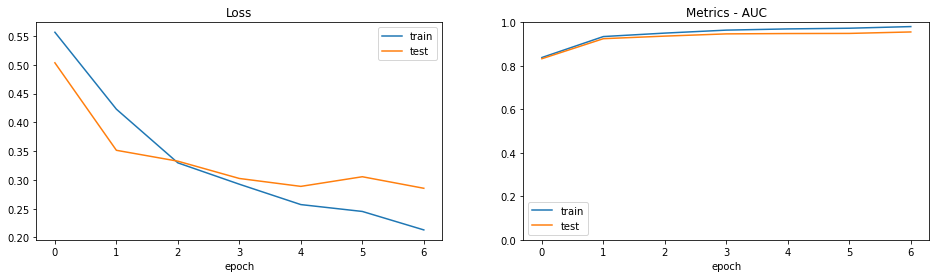

In [ ]:

def get_data(train_ds, test_ds, bs, vocab_size):
    train_dl = DataLoader(train_ds, batch_size = bs, shuffle=True, 
                collate_fn=collate_fn)
    test_dl = DataLoader(test_ds, batch_size = bs, shuffle=False,
                collate_fn=collate_fn)
    return train_dl, test_dl
train_dl, test_dl = get_data(train_ds, test_ds, bs=64, vocab_size=VOCAB_SIZE)
model = SentimentClassifier(embedding_dim=64, vocab_size=3000+1, hidden_size=128).to(device)

loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=5e-4)

history  = fit(epochs=7, model=model, loss_func=loss_fn, 
    opt=optimizer, train_dl=train_dl, valid_dl=test_dl)
plot_results(history=history)